In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import pdb
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler


In [2]:
# 定义数据集根路径
data_dir = '../datasets'

# 定义图像预处理的转换操作
# 定义图像预处理的转换操作，包括数据增强
transform = transforms.Compose([
    # 随机水平翻转
    transforms.RandomHorizontalFlip(),
    # 随机垂直翻转
    transforms.RandomVerticalFlip(),
    # 随机旋转
    transforms.RandomRotation(30),
    # 随机调整图像亮度、对比度和饱和度
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # 调整图像大小
    transforms.Resize((500, 500)),
    # 转换为张量
    transforms.ToTensor(),
    # 归一化
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 创建 ImageFolder 数据集实例
dataset = ImageFolder(root=data_dir, transform=transform)

'''
类别名称列表: ['paper', 'people', 'rock', 'scissor']
类别到索引的映射: {'paper': 0, 'people': 1, 'rock': 2, 'scissor': 3}
'''
class_names = dataset.classes
print("类别名称列表:", class_names)

# 获取类别到索引的映射
class_to_idx = dataset.class_to_idx
print("类别到索引的映射:", class_to_idx)

# 划分训练集和测试集
# 30% 的数据将被用作测试集, 42是一个随机数生成器的种子
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=42)

# 创建训练集和测试集的数据加载器
batch_size = 8 # batch size不要太大，否则内存会爆炸


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



类别名称列表: ['paper', 'people', 'rock', 'scissor']
类别到索引的映射: {'paper': 0, 'people': 1, 'rock': 2, 'scissor': 3}


In [6]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 15 * 15, 128)
        self.fc2 = nn.Linear(128, 4)
        dropout_rate = 0.5
        self.dropout = nn.Dropout(p=dropout_rate)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)

        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [7]:
# 创建神经网络实例
model = ConvNet()
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# Adam优化器
# optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# RMSprop优化器
#optimizer = optim.RMSprop(model.parameters(), lr=0.001)
 
# Adadelta优化器
#optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
# AdamW优化器
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

# 开启混合精度训练，
# GradScaler 用于动态缩放梯度，可以防止出现溢出的情况
scaler = GradScaler()
# 训练模型
num_epochs = 20

train_losses = []
val_losses = []
# 如果验证集损失在多少个 epoch 内未改善，则停止训练
patience = 5
best_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义准确率变量
best_accuracy = 0.0

In [8]:

for epoch in range(num_epochs):
    # 训练模型
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    val_loss = 0
    
    for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', leave=False):
        images = images.to(device)
        labels = labels.to(device)
        with autocast():
        # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            scaler.scale(loss).backward()  # 缩放损失
            scaler.step(optimizer)          # 更新梯度
            scaler.update()                 # 更新缩放器

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()


    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # 记录损失值
    train_accuracy = 100.0 * correct / total

    # 在测试集上进行推断
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            val_loss += criterion(outputs, labels).item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)  # 记录损失值
    test_accuracy = 100.0 * test_correct / test_total
    print(
        f"""Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f},
        Val Loss: {val_loss:.4f}, 
        Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%""")
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  # 重置计数器
    else:
        patience_counter += 1  # 计数器加一
        if patience_counter >= patience:
            print("Early stopping!")
            break
    # 如果准确率有提升，则保存模型
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), './best_model.pt')
    torch.cuda.empty_cache()

Epoch [1/20], Loss: 1.2073,
        Val Loss: 1.1430, 
        Train Accuracy: 33.40%, Test Accuracy: 39.99%


Epoch [2/20], Loss: 0.9551,
        Val Loss: 0.7853, 
        Train Accuracy: 55.43%, Test Accuracy: 67.19%


Epoch [3/20], Loss: 0.6450,
        Val Loss: 0.5436, 
        Train Accuracy: 74.37%, Test Accuracy: 77.97%


Epoch [4/20], Loss: 0.4940,
        Val Loss: 0.4937, 
        Train Accuracy: 80.77%, Test Accuracy: 80.28%


Epoch [5/20], Loss: 0.3968,
        Val Loss: 0.5779, 
        Train Accuracy: 84.71%, Test Accuracy: 76.69%


Epoch [6/20], Loss: 0.3506,
        Val Loss: 0.4665, 
        Train Accuracy: 86.33%, Test Accuracy: 82.59%


Epoch [7/20], Loss: 0.2872,
        Val Loss: 0.4861, 
        Train Accuracy: 89.01%, Test Accuracy: 81.74%


Epoch [8/20], Loss: 0.2383,
        Val Loss: 0.5124, 
        Train Accuracy: 90.68%, Test Accuracy: 83.38%


Epoch [9/20], Loss: 0.2210,
        Val Loss: 0.5027, 
        Train Accuracy: 90.94%, Test Accuracy: 83.81%


Epoch [10/20], Loss: 0.1955,
        Val Loss: 0.5254, 
        Train Accuracy: 92.41%, Test Accuracy: 81.19%


Epoch [11/20], Loss: 0.1844,
        Val Loss: 0.6927, 
        Train Accuracy: 92.46%, Test Accuracy: 83.51%
Early stopping!


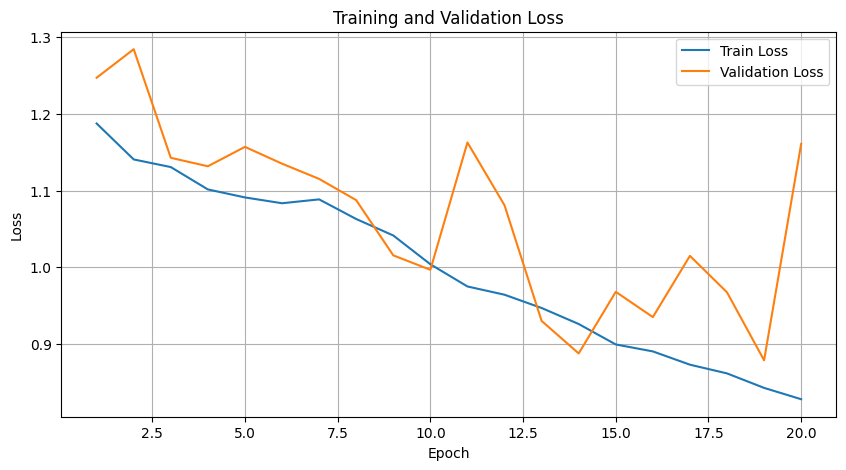

In [ ]:
# 绘制损失变化曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()